In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

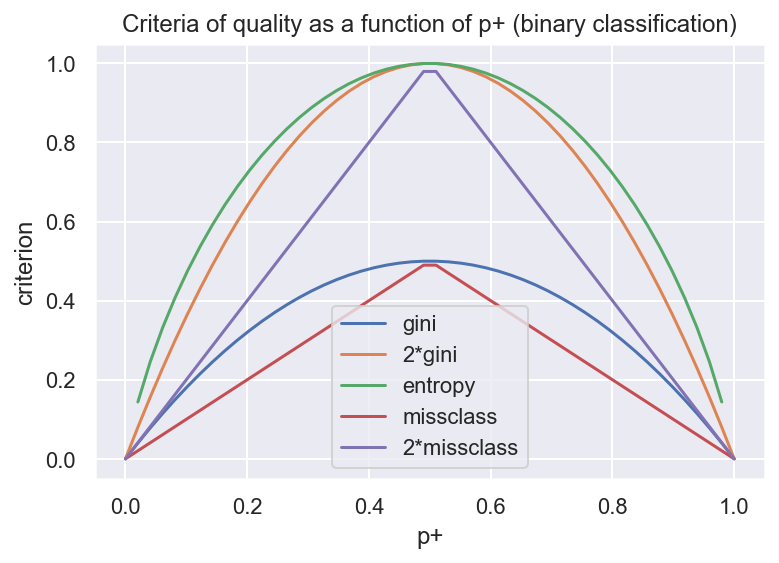

In [2]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0, 1, 50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label="gini")
plt.plot(xx, [4 * x * (1 - x) for x in xx], label="2*gini")
plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")
plt.plot(xx, [1 - max(x, 1 - x) for x in xx], label="missclass")
plt.plot(xx, [2 - 2 * max(x, 1 - x) for x in xx], label="2*missclass")
plt.xlabel("p+")
plt.ylabel("criterion")
plt.title("Criteria of quality as a function of p+ (binary classification)")
plt.legend();

In [3]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

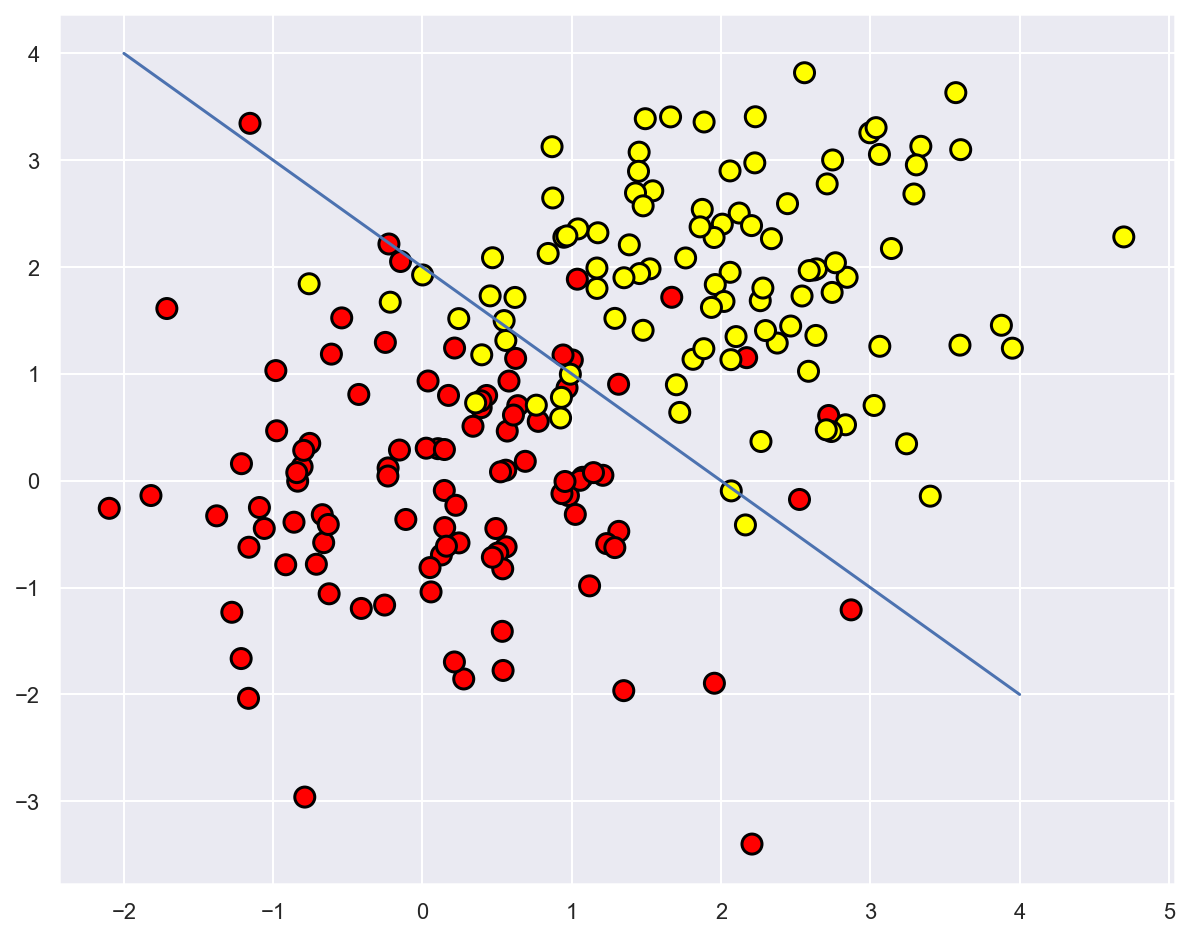

In [4]:
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.plot(range(-2, 5), range(4, -3, -1));

Let's try to separate these two classes by training an Sklearn decision tree. We will use max_depth parameter that limits the depth of the tree. Let's visualize the resulting separating boundary.

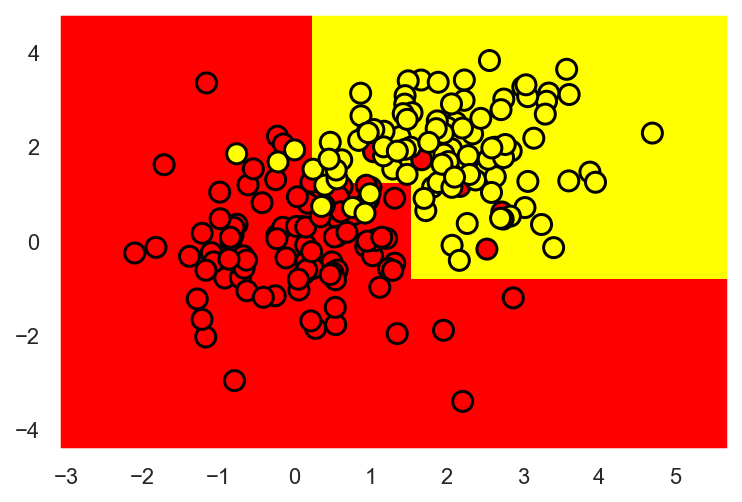

In [5]:
from sklearn.tree import DecisionTreeClassifier


# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
);

And how does the tree itself look? We see that the tree "cuts" the space into 8 rectangles, i.e. the tree has 8 leaves. Within each rectangle, the tree will make the prediction according to the majority label of the objects inside it.

In [6]:
import pydotplus

In [7]:
from sklearn.tree import export_graphviz

In [8]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [9]:
tree_graph_to_png(
    tree=clf_tree,
    feature_names=["x1", "x2"],
    png_file_to_save="tree1.png",
)

In [10]:
data = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [11]:
data.sort_values("Age")

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


In [12]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data["Age"].values.reshape(-1, 1), data["Loan Default"].values)

tree_graph_to_png(
    age_tree,
    feature_names=["Age"],
    png_file_to_save="tree2.png",
)

In [13]:
data2 = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Salary": [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data2

,Age,Salary,Loan Default
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


In [14]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[["Age", "Salary"]].values, data2["Loan Default"].values);

In [15]:
tree_graph_to_png(
    tree=age_sal_tree,
    feature_names=["Age", "Salary"],
    png_file_to_save="tree3.png",
)

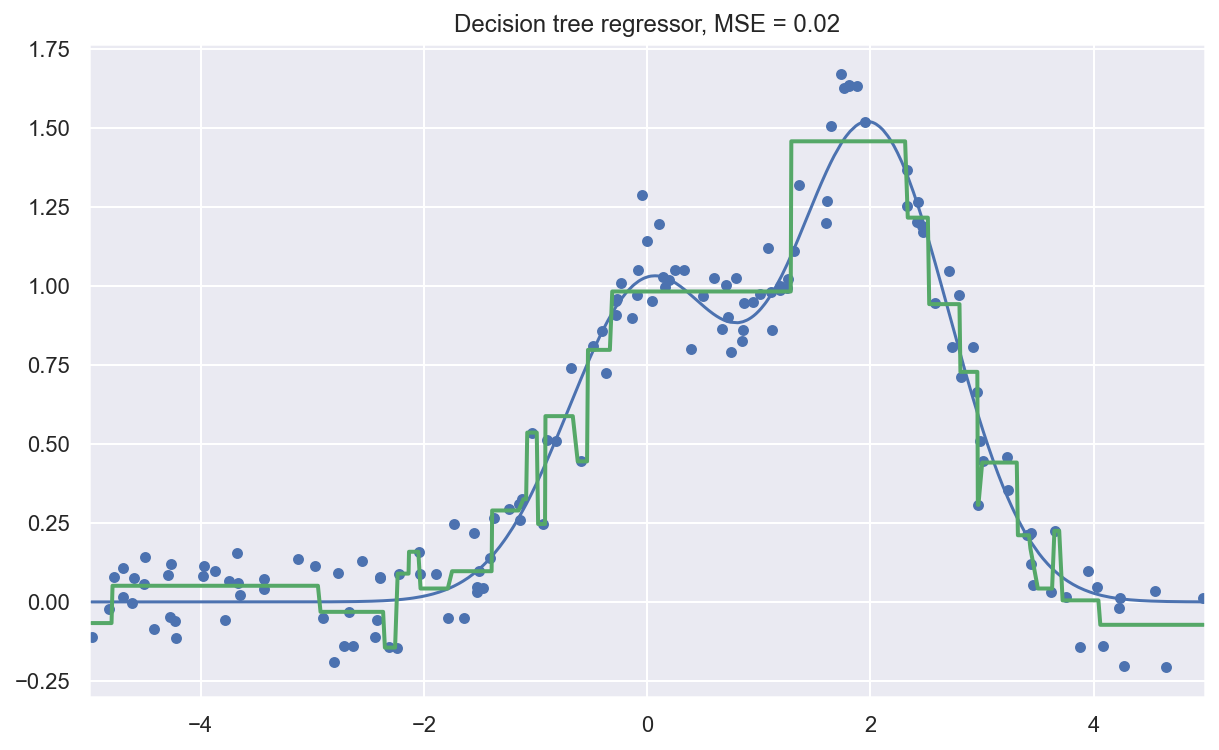

In [16]:
n_train = 150
n_test = 1000
noise = 0.1


def f(x):
    x = x.ravel()
    return np.exp(-(x ** 2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = (
        np.exp(-(X ** 2))
        + 1.5 * np.exp(-((X - 2) ** 2))
        + np.random.normal(0.0, noise, n_samples)
    )
    X = X.reshape((n_samples, 1))
    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title(
    "Decision tree regressor, MSE = %.2f"
    % (np.sum((y_test - reg_tree_pred) ** 2) / n_test)
)
plt.show()